# **Additional models / Hyper parameter tuning**

In this notebook we re-examine the data processing pipeline and create infrustructure to fit additional models. We apply grid search for hyperparameter tuning. 

The notebook is structured as follows:

1. General dataset preparation
2. Model input preparation
3. Model development
4. Hyperparameter tuning
5. Final model 



In [1]:
# Data Manipulation
import pandas as pd
import numpy as np

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style()

# Text processing
import nltk
from nltk import FreqDist, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from gensim import corpora, models
from gensim.models import Word2Vec

# Deep learning
import keras
from keras import Input, Model, regularizers
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.layers import Dense, Dropout, Embedding, LSTM
from keras.engine.saving import load_model
from keras.models import Sequential
from keras.preprocessing import text
from keras.preprocessing.sequence import pad_sequences

# Data Processing Pipeline & Metrics
from sklearn import metrics
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, f1_score, roc_curve, roc_auc_score, confusion_matrix
from sklearn.model_selection import cross_val_score, KFold
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# Miscellaneous
import string
import umap
import inspect

Using TensorFlow backend.


# **1. General dataset preparation**

Here we load all the data needed for the analysis and perform general transformations such as: 1) delete/examine cetain suspicious opservations 2) impute missing values  3) create new variables 4) combine test and validation sets 5) balance training data

In [2]:
# General controllers

balance_data = False
combine_train_and_val = False

Load the data

In [3]:
# Training data
X_train = pd.read_csv("../input/diab_train.csv", index_col=0)

# Validation set
X_val = pd.read_csv("../input/diab_validation.csv", index_col=0)
Y_val = X_val["readmitted"]
len_val = len(X_val)

# Test set
X_test  = pd.read_csv("../input/diab_test.csv", index_col=0)
Y_test = X_test["readmitted"]
len_test = len(X_test)

# Combine all together
X_Y_all = pd.concat([X_train, X_val, X_test]).reset_index(drop=True)
X_Y_all["partition"] = np.concatenate([np.repeat("train", len(X_train)), np.repeat("val", len(X_val)), np.repeat("test", len(X_test))])

# Drop Y from X_test. We will do the same for X_train, and X_val after we balance the data
X_test = X_test.drop(columns="readmitted")

### **Step 1:** delete/examine some strange observations. 


During the dataset exploration we have discovered data subjects, that could be irrelevant for our analysis. We are considering two approaches to handle these cases:

* delete these cases from the training set (if there is nothing similiar in validation/test) sets
* treat certain "unusual" attributes as missing data


**Suspicious case 1**

1 newborn, who was later not readmitted, such cases do not exist in validation/test set

In [4]:
X_Y_all.loc[X_Y_all['admission_type_id'] == "Newborn", ["partition", 'readmitted']]

,partition,readmitted
3197,train,0


his diagnosis was:

In [5]:
txt1 = X_Y_all.loc[X_Y_all['admission_type_id'] == "Newborn", 'diag_1_desc'].values[0]
txt2 = X_Y_all.loc[X_Y_all['admission_type_id'] == "Newborn", 'diag_2_desc'].values[0]
txt3 = X_Y_all.loc[X_Y_all['admission_type_id'] == "Newborn", 'diag_3_desc'].values[0]

diagn = "{}\n{}\n{}".format(txt1, txt2, txt3)
print(diagn)

Diverticulosis of small intestine (without mention of hemorrhage)
Congestive heart failure, unspecified
Diabetes with ophthalmic manifestations, type II or unspecified type, uncontrolled


This observation appears to be relevant, yet it creates a challenge for treating `admission_type_id` as an ordered variable. I would propose to encode it as a missing value and re-impute it later

In [6]:
X_train.loc[X_train['admission_type_id'] == "Newborn", 'admission_type_id'] = np.nan

### **Step 2:** missing values imputation

When dealing with missing values we have three main options

1. use an algorithm to impute missing values 
2. encode missing value as a separate category, or assign certain value
3. exclude the variable from the subsequent analysis 

We would like to take a look at the structure of missingness in the data. Our objective is to do a preliminary check, whether we can observe a pattern. 

Three situations might take place:

* Missing completely at random (MCAR)
* Missing at random (MAR)
* Missing not at random (MNAR)

In case **MCAR** and **MAR** it is reasonable to try to impute missing values, whereas in case **MNAR** and procedure might lead to biases, therefore at least for categorical variables, it would be reasonable to eoncode this state separately or entirely exclude them from the analysis


The code at the beginning of the `readmission_prediction` notebook  allows us to examine unique values of different variables. Based on this we have concluded that the following entries (alongsize with standard np.nan) encodes the fact that the variable is missing

**Comment** some visualizations can be found in the notebook `readmission_prediction.ipynb`

In [7]:
missing_symbols = ['?', 'None','Not Available', 'Not Mapped'] # ["", " ", 'NaN'] # - adding does not change the numbers

for val in missing_symbols:
    X_train = X_train.replace(val, np.nan)
    X_val = X_val.replace(val, np.nan)
    X_test = X_test.replace(val, np.nan)

# list variables with predominantly missing values
missing_threshold = 0.4  

missing_value = X_train.apply(lambda x: sum(x.isnull())/len(X_train) ).sort_values(ascending=False)
mostly_missing = list(missing_value[missing_value > missing_threshold].index)

**Preliminary pragmatic solution is to:** 

1. exclude variables `weight`, `max_glu_serum`, `A1Cresult` from the analysis
2. encode `payer_code`, `medical_specialty`, `discharge_disposition_id`, `diag_1(2,3)_desc` as a separate level
3. impute missing values for `admission_type_id`, `admission_source_id` and `race`

In [8]:
vars_to_delete = ["weight", "max_glu_serum", "A1Cresult"]

vars_to_reencode =  ["payer_code", "medical_specialty", "discharge_disposition_id", 
                     "diag_1_desc", "diag_2_desc", "diag_3_desc"]

vars_to_impute = ["admission_type_id", "admission_source_id", "race"]

In [9]:
for var in vars_to_reencode:
    
    X_train[var] = X_train[var].replace(np.nan, " ")
    X_test[var] = X_test[var].replace(np.nan, " ")
    X_val[var] = X_val[var].replace(np.nan, " ")
    
assert(any(X_train[vars_to_reencode].isnull().any()) == False)

**Impute missing values**

We use a [SimpleImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html) to fill in the missing values

**Note:** We have tried to perform [multivariate feature imputation](https://scikit-learn.org/stable/modules/impute.html), however current implementation of the algorithm does not work with categorical variables

In [10]:
imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

X_train[vars_to_impute] = imp.fit_transform(X_train[vars_to_impute])
# No information leaking -> fit on train, and use this transformation on everything else
X_val[vars_to_impute] = imp.transform(X_val[vars_to_impute])
X_test[vars_to_impute] = imp.transform(X_test[vars_to_impute])

assert(any(X_train[vars_to_impute].isnull().any()) == False)

### **Step 3:** create new variables

We do some small feature engineering. This step is not vital in the deep learning framework, however it might be relevant for dealing with **ordinal** variables. 

For **ordinal** variables, we have decided to perform integer mapping and treat them as numeric values later. This is not an optimal approach since this assumes that the distance between different categories is the same. To be more precise this is a valid assumption for `age` and `weight` since "[10-20] - [0-10)" $\approx$ "[30-40] - [20-30)", however the same does not necessarily hold for `admission_type_id` with *Emergency* - *Urgent* $\geq ? \leq$ *Urgent* - *Elective*

In [11]:
age_encode_dict = {"[0-10)":1, "[10-20)":2, "[20-30)":3, "[30-40)":4, 
                   "[40-50)":5, "[50-60)":6, "[60-70)":7, "[70-80)":8,
                   "[80-90)":9, "[90-100)":10 }

admission_type_dict = {"Elective":1, "Urgent":2, "Emergency":3}


def encode_variables(var_category:str, category_dict=age_encode_dict):
    """
    >>> encode_variables("[0-10)")
    """
    return category_dict.get(var_category, np.nan)

In [12]:
X_train["age_category"] = X_train["age"].apply(encode_variables)
X_train["admission_type_id_category"] = X_train["admission_type_id"].apply(lambda x: encode_variables(x, admission_type_dict))

X_val["age_category"] = X_val["age"].apply(encode_variables)
X_val["admission_type_id_category"] = X_val["admission_type_id"].apply(lambda x: encode_variables(x, admission_type_dict))

X_test["age_category"] = X_test["age"].apply(encode_variables)
X_test["admission_type_id_category"] = X_test["admission_type_id"].apply(lambda x: encode_variables(x, admission_type_dict))


assert(any(X_train[["age_category", "admission_type_id_category"]].isnull().any()) == False)

### **Step 4:** combine test and validation sets

In [13]:
if combine_train_and_val:
    X_train = pd.concat([X_train, X_val]).reset_index(drop=True)
else:
    X_val = X_val.drop(columns="readmitted")

### **Step 5:** balance training data


In [14]:
if balance_data:
    positives = X_train[X_train["readmitted"] == 1]
    negatives = X_train[X_train["readmitted"] == 0]
    oversampled = positives.sample(int(0.5 * len(X_train) - len(positives)), replace=True)
    undersampled = negatives.sample(int(0.5 * len(X_train)), replace=True)
    X_train = pd.concat([positives, oversampled, undersampled]).reset_index(drop=True)
    
try: # error is raised by running this cell twice
    Y_train = X_train["readmitted"]
    X_train = X_train.drop(columns="readmitted")
except:
    pass

## **All together**

the function below combines all the steps from the described pipeline

In [15]:
vars_to_delete = ["weight", "max_glu_serum", "A1Cresult"]
vars_to_reencode =  ["payer_code", "medical_specialty", "discharge_disposition_id", 
                     "diag_1_desc", "diag_2_desc", "diag_3_desc"]
vars_to_impute = ["admission_type_id", "admission_source_id", "race", "age"]
missing_symbols = ['?', 'None','Not Available', 'Not Mapped']



def data_loading_preprocessing(balance_data=False,
                               combine_train_and_val=False,
                               encode_as_missing=True,
                               missing_symbols=missing_symbols,
                               vars_to_delete=vars_to_delete,
                               vars_to_reencode=vars_to_reencode,
                               vars_to_impute=vars_to_impute ):
    """
    Usage/Testing
    >>> X_train, Y_train, X_val, Y_val, X_test, Y_test = data_loading_preprocessing()
    """
    # Training data
    X_train = pd.read_csv("../input/diab_train.csv", index_col=0)
    # Validation set
    X_val = pd.read_csv("../input/diab_validation.csv", index_col=0)
    Y_val = X_val["readmitted"]
    # Test set
    X_test  = pd.read_csv("../input/diab_test.csv", index_col=0)
    Y_test = X_test["readmitted"]

    # Drop Y from X_test. We will do the same for X_train, and X_val after we balance the data
    X_test = X_test.drop(columns="readmitted")
    X_train.loc[X_train['admission_type_id'] == "Newborn", 'admission_type_id'] = np.nan
    
    # Replace variables in "missing symbols" by np.nan
    if encode_as_missing:
        for val in missing_symbols:
            X_train = X_train.replace(val, np.nan)
            X_val = X_val.replace(val, np.nan)
            X_test = X_test.replace(val, np.nan)

    for var in vars_to_reencode:

        X_train[var] = X_train[var].replace(np.nan, " ")
        X_test[var] = X_test[var].replace(np.nan, " ")
        X_val[var] = X_val[var].replace(np.nan, " ")

    assert(any(X_train[vars_to_reencode].isnull().any()) == False)

    imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

    X_train[vars_to_impute] = imp.fit_transform(X_train[vars_to_impute])
    # No information leaking -> fit on train, and use this transformation on everything else
    X_val[vars_to_impute] = imp.transform(X_val[vars_to_impute])
    X_test[vars_to_impute] = imp.transform(X_test[vars_to_impute])

    assert any(X_train[vars_to_impute].isnull().any()) == False, "problem with missing variable imputation"

    X_train["age_category"] = X_train["age"].apply(encode_variables)
    X_train["admission_type_id_category"] = X_train["admission_type_id"].apply(lambda x: encode_variables(x, admission_type_dict))

    X_val["age_category"] = X_val["age"].apply(encode_variables)
    X_val["admission_type_id_category"] = X_val["admission_type_id"].apply(lambda x: encode_variables(x, admission_type_dict))

    X_test["age_category"] = X_test["age"].apply(encode_variables)
    X_test["admission_type_id_category"] = X_test["admission_type_id"].apply(lambda x: encode_variables(x, admission_type_dict))
    
    assert(any(X_train[["age_category", "admission_type_id_category"]].isnull().any()) == False)

    if combine_train_and_val:
        X_train = pd.concat([X_train, X_val]).reset_index(drop=True)
    else:
        X_val = X_val.drop(columns="readmitted")

    if balance_data:
        positives = X_train[X_train["readmitted"] == 1]
        negatives = X_train[X_train["readmitted"] == 0]
        oversampled = positives.sample(int(0.5 * len(X_train) - len(positives)), replace=True)
        undersampled = negatives.sample(int(0.5 * len(X_train)), replace=True)
        X_train = pd.concat([positives, oversampled, undersampled]).reset_index(drop=True)

    Y_train = X_train["readmitted"]
    X_train = X_train.drop(columns="readmitted")
    
    return X_train, Y_train, X_val, Y_val, X_test, Y_test


# **Input Preparation**

After cleaning the dataset, we work with individual variables. Variables in the dataset can be divided into several groups: **Numeric**, **Categorical** and **Textual**. Each subgroup requires individual approach furthermore feature transformation can differ depending on the selected neural network architecture. This and other aspects will be discussed below.


Our choices are informed by the plots in `readmission_prediction.ipynb`. Most of the functions below are modified/extended versions of the feature preprocessing introduced in `models_final.ipynb`

### **Numeric input**

Numeric input preprocessing comprises the following steps

1. **Variable transformation:** upon examining histrograms and scatter plots of numeric variables we have noticed that variables `number_outpatient`, `number_emergency` have a couple of outlier values $\Rightarrow$ might want to reduce their influence by transforming the variables.

2. **Normalization.**  Normalization is performed using values of the *training* set only, to transform  *test* and *validation* set we pass the normalizer fitted on the training data as a function argument

In [16]:
numerical_features = ["time_in_hospital", "num_procedures", 
                      "number_outpatient", "number_emergency", 
                      "number_inpatient", "number_diagnoses",
                      "num_medications", "num_lab_procedures",
                      # add integer encoded ordinal variables
                      "age_category", "admission_type_id_category"
                     ]



sqrt_transform_features = ["number_outpatient", "number_emergency"]

def get_numerical_inputs(df_in: pd.DataFrame, 
                         numerical_features = numerical_features,
                         sqrt_transform_features = sqrt_transform_features,
                         normalizer = None
                        ):

    df = df_in.copy()
    
    # some columns have extreme values:
    for var in sqrt_transform_features:
        df[var] = df[var].apply(lambda x: np.sqrt(x + 0.5))

    if normalizer == None:
        normalizer = Pipeline([("normalize", StandardScaler())])
        numerical_inputs = normalizer.fit_transform(df[numerical_features])
        
    else:
        numerical_inputs = normalizer.transform(df[numerical_features])
    
    return numerical_inputs, normalizer


### **Categorical input**

Dataset contains various categorical features, which we have divided into the following 3 groups:  

* **medications**: **23** variables corresponding to different treatments prescribed to patients 
* **diagnostics code**: ICD9 codes of the patient's primary (secondary) diagnosis in 
* **general** contain different categorical features that do not require specific preprocessing steps apart from One Hot encoding

#### **General features**

In [17]:
categorical_features = ["race", "gender", 
                        
                        # "age",  "admission_type_id",     # used in the model as age_category and  admission_type_id_category
                        #"max_glu_serum", "A1Cresult",     # delete due too many missing variables

                        "payer_code", "medical_specialty",  # a lot of missing values, exclude?
                        
                        "change", "diabetesMed", 
                        "admission_source_id", 
                        "discharge_disposition_id"]


def get_categorical_inputs(df_in: pd.DataFrame,
                           categorical_features=categorical_features,
                           encoder=None):
    """
    Usage
    >>> input_categ, enc = get_categorical_inputs(X_train)
    >>> input_categ_test, _ = get_categorical_inputs(X_train, encoder=enc)
    """
    df = df_in.copy()
        
    # admission_source_id and discharge_disposition_id are heavily imbalanced
    # and increase the input dimension too much:
    admi_type_id_keep = ["Emergency Room", "Physician Referral", 'Transfer from a hospital', 'Transfer from another health care facility']
    df[~df.admission_source_id.isin(admi_type_id_keep)] = "other"
    dis_dis_id_keep = ['Discharged to home', 'Discharged/transferred to SNF', 'Discharged/transferred to home with home health service']
    df[~df.discharge_disposition_id.isin(dis_dis_id_keep)] = "other"

    if encoder == None:
        encoder = OneHotEncoder(handle_unknown='ignore')
        categorical_inputs = encoder.fit_transform(df[categorical_features]).toarray()
    else:
        categorical_inputs = encoder.transform(df[categorical_features]).toarray()
    
    return categorical_inputs, encoder


#### **Information about medications**

This group of variables is preprocessed as follows:

1. **Input selection**. Plots in`readmission_prediction.ipynb` indicate that most of the drugs are prescribed extremely rarely (to less than 10% of the patients) $\Rightarrow$ use information from the *training* set to exclude the rarest drugs.

2. **Input encoding** Variables in this category can take 4 values: "No", "Steady", "Up", "Down", whereby the majority is "No". We experiment with two types of encodings: a) 0 - "No" vs 1 - any other b) 0 - "No", 1 - "Steady", 2 - "Up", 3 - "Down"
 

In [18]:
medicine_all = ["metformin", "repaglinide", "nateglinide", "chlorpropamide", "glimepiride", 
                "acetohexamide", "glipizide", "glyburide", "tolbutamide", "pioglitazone", "rosiglitazone", 
                "acarbose", "miglitol", "troglitazone", "tolazamide", "examide", "citoglipton", "insulin", 
                "glyburide.metformin", "glipizide.metformin", "glimepiride.pioglitazone", 
                "metformin.rosiglitazone", "metformin.pioglitazone"]


def get_medicine_inputs(df_in: pd.DataFrame, 
                        medicine_all = medicine_all,
                        perc_no_values_thresold = None,
                        medicine_to_return = None,
                        is_binary_output = True,
                        encoder = None,
                       ):
    """
    :param perc_no_values_thresold  if the percentage of missing values exceeds this 
                                    threshold -> exclude it from the subsequent analysis
                                    
    :param is_binary_output:        if yes, encode as a binary variable
    
    Usage/Testing:
    >>> med_input, medicine_thresh, encoder = get_medicine_inputs(X_train, perc_no_values_thresold=0.95)
    >>> med_input_test, _, _ = get_medicine_inputs(X_test, medicine_to_return=medicine_thresh )
    
    """
    if (medicine_to_return == None) and (perc_no_values_thresold==None):
        # Need to ensure that the list of medicines is the same for train, test and validate datasets !
        print("You need to provide either perc_no_values_thresold or a list of drugs to return")
        raise Exception
    
    df = df_in.copy()
    # categorical: {up, down, steady, no}

    if medicine_to_return==None:
        # the histograms show that for majority of medicine there is little information
        medicine_to_return = []
        for med in medicine_all:
            perc_no_values = (df[med]=="No").sum() / df.shape[0]
            if perc_no_values < perc_no_values_thresold:  # 90% leaves 4 medicines
                medicine_to_return.append(med)

        print("{} drugs left (out of {}) after filtering with threshold {}: \n".format(len(medicine_to_return), len(medicine_all), perc_no_values_thresold))
    
    
    if is_binary_output:
        to_binary = FeatureModifier(features=medicine_to_return, func=(lambda x: 0 if x == "No" else 1))
        medicine_inputs = to_binary.transform(df)
        enc = None
    
    else:  
        if encoder == None:
            encoder = OneHotEncoder(handle_unknown='ignore')
            medicine_inputs = encoder.fit_transform(df_in[medicine_to_return])
        else:
            medicine_inputs = encoder.transform(df_in[medicine_to_return])
    
    return medicine_inputs, medicine_to_return, encoder


#### **Diagnosis code**


In [19]:
def map_ICD9_to_class (x):
    x = str(x)
    try:
        if(x.startswith("E")):
            return 0
        if(x.startswith("V")):
            return 1
        if x.split(".")[0] == "?":
            return 0
        if str(x) == 'nan':
            return 0
        if x == np.nan:
            return 0
    except:
        pass
    
    breakpoints = [0, 140, 240, 280, 290, 320, 390, 460, 520, 580, 630, 680, 710, 740, 760, 780, 800]
    breakpoints.reverse()
    class_nr = len(breakpoints) - 1
    for bp in breakpoints:
        if int(x.split(".")[0]) >= bp:
            return class_nr
        class_nr = class_nr - 1

In [20]:
diagnosis_codes = ["diag_1", "diag_2", "diag_3"]
        
def get_diags_inputs(df_in: pd.DataFrame,
                     diagnosis_codes=diagnosis_codes):
    """this version combines all three diagnosis in one vector, using the OR-function"""
    df = df_in.copy()
    diag_in_classes = df[diagnosis_codes].applymap(map_ICD9_to_class)
    max_class_num = diag_in_classes.values.max()
    diags_inputs = np.zeros((len(df), max_class_num + 1))
    for index, row in diag_in_classes.iterrows():
        diags_inputs[index, row["diag_1"]] = 1
        diags_inputs[index, row["diag_2"]] = 1
        diags_inputs[index, row["diag_3"]] = 1
    
    return diags_inputs


## **Textual input**

Our goal is to include the variables `diag_1_desc`,  `diag_2_desc` and  `diag_3_desc` in the model.

We have considered the following options to represent the sentence:

* every sentence is a tockenized and encoded as a sequence of integers with a fixed length `max_len` (get_model_lstm_own_embedding)
* every sentence is represented by a matrix with dimension `max_len` x `embedding_size`. This representation can be obtained by i.e. **Word2Vec** (get_model_lstm_embedding_ready)
* every sentence is represented by a vector of a fixed size. This representation can be obtained by i.e. **tf-idf** or **word2doc** (get_model_tfdif)


First we perform some basic preprocessing of the text, consisting of **word tokenization**, **normalization**, **stemming**. 

In [21]:
# select features
class Selector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

# impute missing values
class MissingChanger(BaseEstimator, TransformerMixin):
    def __init__(self, features, constant):
        self.features = features
        self.constant = constant
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.features].fillna(self.constant)

# apply function to some features
class FeatureModifier(BaseEstimator, TransformerMixin):
    def __init__(self, features, func):
        self.features = features
        self.func = func
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        Xnew = X.copy()[self.features]
        Xnew = Xnew[self.features].applymap(lambda x: self.func(x))
        return np.array(Xnew)
    
# textual transformations
class TokenizerOur(BaseEstimator, TransformerMixin): # there is a naming conflict due to keras.preprocessing.text.Tokenizer
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X.applymap(lambda x: word_tokenize(x))
   

class StopWordsFilter(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.stopwords = stopwords.words('english') + list(string.punctuation)
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X.applymap(lambda x: [word for word in x if word not in self.stopwords])

    
class Stemmer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.stemmer = PorterStemmer()
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X.applymap(lambda x: [self.stemmer.stem(word) for word in x])

    
class ToStringList(BaseEstimator, TransformerMixin):
    def __init__(self, features_to_group):
        self.features_to_group = features_to_group 
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        string_list = []
        for index, row in X.iterrows():
            entry = []
            for feat in self.features_to_group:
                entry.extend(row[feat])
            string_list.append(" ".join(entry))
        return string_list
    

In [22]:
diagnosis_descriptions = ["diag_1_desc", "diag_2_desc", "diag_3_desc"]

textual_preprocessing_pipeline = Pipeline([
        ("select_textual_features", Selector(diagnosis_descriptions)),
        ("add_missing_class", MissingChanger(diagnosis_descriptions, "")),
        ("tokenize", TokenizerOur()),
        ("filter_stop_words", StopWordsFilter()),
        ("perform_stemming", Stemmer()),
    ])

# do not exclude stop words
textual_preprocessing_pipeline_short = Pipeline([
    ("select_textual_features", Selector(diagnosis_descriptions)),
    ("tokenize", TokenizerOur()),
    ("perform_stemming", Stemmer())
])

#### **Get a tockenized sentence**

In [23]:
#------------------------------------ IMPORTANT CONSTANTS: (change later)
#textual_preprocessing_pipeline_short

def get_tockenized_sentence(df: pd.DataFrame,
                            train=False,
                            tokenizer=None,
                            num_words_tockenize = 500, #num_words_tockenize,
                            max_sentence_len = 25,#max_sentence_len,
                            pipeline = textual_preprocessing_pipeline
                           ):
    """
    :param train: sentences in X_train and all the other datasets should be transformed using the same tockenizer, 
                  othersize the representation might not be useful for prediction

                  train = true: train the tokinizer on the df
                  train = false: transform the text from the df using the provided tokenizer
                  
    :param num_words_tockenize
                  the maximum number of words to keep, based on word frequency. 
                  Only the most common num_words-1 words will be kept.
                  
    :param max_sentence_len
                  after the preprocessing most of the diagnosis are no longer than
                  25 words, therefore the value probably should not exceed 25
                  
    :return:      for each diagnosis we get a sequence of integers, padded with 0
                  of total length `max_sentence_len`
    
    Usage:
    >>> diag1, diag2, diag3, tockinizer_train = get_tockenized_sentence( X_train, train=True )
    >>> diag1_tst, diag2_tst, diag3_tst, _ = get_tockenized_sentence( X_test, train=False, tockenizer=tockinizer_train )
    """
    if (not train) and tokenizer==None:
        print("Need either to train a model or to provide a tockenizer")
        raise Exception
    
    # Replace missing values (should be redundand now due to step 3 in data preprocessing section)
    df["diag_1_desc"] = df["diag_1_desc"].replace(np.nan, " ")
    df["diag_2_desc"] = df["diag_2_desc"].replace(np.nan, " ")
    df["diag_3_desc"] = df["diag_3_desc"].replace(np.nan, " ")

    # prepare all text information 
    # as a result, a sentence is an array of key words
    if tokenizer == None:
        df_transformed = textual_preprocessing_pipeline.fit_transform(df)
    else:
        df_transformed = textual_preprocessing_pipeline.transform(df)
    df_transformed_all = np.concatenate([df_transformed[feature].values for feature in diagnosis_descriptions])
   
    
    # represent a sentence as  a sequence of integers
    if tokenizer == None:
        tokenizer = text.Tokenizer(num_words=num_words_tockenize)
        tokenizer.fit_on_texts(df_transformed_all)

    vocab_size = len(tokenizer.word_index) + 1 
    #print("Vocabulary size for the diagnosis is: {}".format(vocab_size))

    # Encode text to sequence
    inp_nlp_diag1 = tokenizer.texts_to_sequences( list(df_transformed["diag_1_desc"].values) ) 
    inp_nlp_diag2 = tokenizer.texts_to_sequences( list(df_transformed["diag_2_desc"].values) )
    inp_nlp_diag3 = tokenizer.texts_to_sequences( list(df_transformed["diag_3_desc"].values) ) 

    # Pad to achieve the desired sequence length
    inp_nlp_diag1_fin = pad_sequences(inp_nlp_diag1, maxlen = max_sentence_len, padding="post")
    inp_nlp_diag2_fin = pad_sequences(inp_nlp_diag2, maxlen = max_sentence_len, padding="post")
    inp_nlp_diag3_fin = pad_sequences(inp_nlp_diag3, maxlen = max_sentence_len, padding="post")
    
    return inp_nlp_diag1_fin, inp_nlp_diag2_fin, inp_nlp_diag2_fin, tokenizer, vocab_size

#### **Get an embedded sentence**

We use a word embedding algorithm to represent all the sentences as matrices of potentially fixed length. 

**NB** we are not certain whether it would be really different from just feeding a tokenized sentence to an Embedding layer

In [24]:
def get_embedded_sentence(df,
                          pipeline = textual_preprocessing_pipeline,
                          w2v_embedding_size = 30,
                          embed_model = None,
                          max_sent_len = 6
                         ):
    """
    >>> inp_mtr_1, inp_mtr_2, inp_mtr_3, embed_model = get_embedded_sentence(X_train)
    >>> inp_mtr_1, inp_mtr_2, inp_mtr_3, embed_model = get_embedded_sentence(X_train, embed_model=embed_model)
    """
    
    transformed_text = pipeline.fit_transform(df)
    transformed_text_all = np.concatenate([transformed_text[feature].values for feature in diagnosis_descriptions])

    if embed_model==None:
        embed_model = Word2Vec(transformed_text_all, 
                               size=w2v_embedding_size,          # Dimensionality of the word vectors.
                               min_count=1)        # Ignores all words with total frequency lower than this.

    #----------- Initialize 3 embedding matrices for all 3 input variables
    df_size = df.shape[0]
    problem_words = []
    
    inp_mtr_1 = np.zeros(( df_size, max_sent_len, w2v_embedding_size ))
    inp_mtr_2 = np.zeros(( df_size, max_sent_len, w2v_embedding_size ))
    inp_mtr_3 = np.zeros(( df_size, max_sent_len, w2v_embedding_size ))
    
    cnt = 0
    for i in range(df_size):
        for j in range(max_sent_len):
            if len( transformed_text.loc[i, 'diag_1_desc'] ) > j:
                cnt+=1
                try:
                    inp_mtr_1[i, j, :] = embed_model.wv[transformed_text.loc[i, 'diag_1_desc'][j]]
                except Exception as e:
                    # encode with 1 all out of vocabulary words
                    #print(e)
                    inp_mtr_1[i, j, :] = np.ones(w2v_embedding_size)
                    problem_words.append(transformed_text.loc[i, 'diag_1_desc'][j])
            else:
                inp_mtr_1[i, j, :] = np.zeros(w2v_embedding_size)
                
    for i in range(df_size):
        for j in range(max_sent_len):
            if len( transformed_text.loc[i, 'diag_2_desc'] ) > j:
                cnt+=1
                try:
                    inp_mtr_2[i, j, :] = embed_model.wv[transformed_text.loc[i, 'diag_2_desc'][j]]
                except Exception as e:
                    # encode with 1 all out of vocabulary words
                    #print(e)
                    inp_mtr_2[i, j, :] = np.ones(w2v_embedding_size)
                    problem_words.append(transformed_text.loc[i, 'diag_2_desc'][j])
            else:
                inp_mtr_2[i, j, :] = np.zeros(w2v_embedding_size)
    
    
    for i in range(df_size):
        for j in range(max_sent_len):
            if len( transformed_text.loc[i, 'diag_3_desc'] ) > j:
                cnt+=1
                try:
                    inp_mtr_3[i, j, :] = embed_model.wv[transformed_text.loc[i, 'diag_3_desc'][j]]
                except Exception as e:
                    # encode with 1 all out of vocabulary words
                    #print(e)
                    inp_mtr_3[i, j, :] = np.ones(w2v_embedding_size)
                    problem_words.append(transformed_text.loc[i, 'diag_3_desc'][j])
            else:
                inp_mtr_3[i, j, :] = np.zeros(w2v_embedding_size)

    print("{} out of {} words could not be encoded".format(len(problem_words), cnt))    
    
    return inp_mtr_1, inp_mtr_2, inp_mtr_3, embed_model


#### **Sencence as vector**

Every diagnosis is represented as a vector of a fixed size. We implement the following too approaches to get this representation:

1. every sentence is a row in the matrix of TF-IDF features (from `models_final.ipynb`)
2. every sentence is the average of the **word2vec** representations of the terms

In [25]:
def get_diags_descs_tfidf(df: pd.DataFrame,
                          diags_descs_to_tfidf=None,
                          min_df=400, 
                          max_df=None):
    """
    Convert a collection of all diagnoses to a matrix of TF-IDF features.
    
    Usage / Testing
    >>> inputs_textual, to_idf = get_diags_descs_tfidf(X_train)
    >>> inputs_textual, _ = get_diags_descs_tfidf(X_test, diags_descs_to_tfidf=to_idf)
    """
    diagnosis_descriptions = ["diag_1_desc", "diag_2_desc", "diag_3_desc"]
    
    if max_df == None:
        max_df = int(len(df) * 0.7)
      
    if diags_descs_to_tfidf == None:
        diags_descs_to_tfidf = Pipeline([
            ("select_textual_features", Selector(diagnosis_descriptions)),
            ("add_missing_class", MissingChanger(diagnosis_descriptions, "")),
            ("tokenize", TokenizerOur()),
            ("filter_stop_words", StopWordsFilter()),
            ("perform_stemming", Stemmer()),
            ("to_string_list", ToStringList(diagnosis_descriptions)),
            # distribution plot of word count revealed that the vast majority of word only 
            # appears in a very small number of docs, that's why we filter them out
            ('vectorizer', TfidfVectorizer(min_df=min_df, max_df=max_df)),
        ])
        tfidf_out = diags_descs_to_tfidf.fit_transform(df).toarray()
    
    else:
        tfidf_out = diags_descs_to_tfidf.transform(df).toarray()
    
    for channel in range(tfidf_out.shape[1]):
        tfidf_out[:, channel] -= np.mean(tfidf_out[:, channel])
        tfidf_out[:, channel] /= np.std(tfidf_out[:, channel])

    return tfidf_out, diags_descs_to_tfidf

In [26]:
def get_embedded_average(df,
                         pipeline = textual_preprocessing_pipeline,
                         w2v_embedding_size = 30,
                         embed_model = None
                         ):
    """
    >>> diag_vec_1, diag_vec_2, diag_vec_3, embed_model = get_embedded_average(X_train)
    >>> diag_vec_1, diag_vec_2, diag_vec_3, _ = get_embedded_average(X_train, embed_model=embed_model)
    """
    
    transformed_text = pipeline.fit_transform(df)
    transformed_text_all = np.concatenate([transformed_text[feature].values for feature in diagnosis_descriptions])

    if embed_model==None:
        embed_model = Word2Vec(transformed_text_all, 
                               size=w2v_embedding_size,          # Dimensionality of the word vectors.
                               min_count=1)        # Ignores all words with total frequency lower than this.

    #----------- Initialize 3 embedding matrices for all 3 input variables
    df_size = df.shape[0]
    problem_words = []
    
    diag_vec_1 = np.zeros(( df_size, w2v_embedding_size ))
    diag_vec_2 = np.zeros(( df_size, w2v_embedding_size ))
    diag_vec_3 = np.zeros(( df_size, w2v_embedding_size ))
    

    for i in range(df_size):
        cnt1 = 0
        for j in range( len(transformed_text.loc[i, 'diag_1_desc']) ):
            try:
                cnt1 += 1
                diag_vec_1[i, :] += embed_model.wv[transformed_text.loc[i, 'diag_1_desc'][j]]
            except Exception as e:  
                pass
        if cnt1 > 0:
            diag_vec_1[i, :] /= cnt1
        
    for i in range(df_size):
        cnt2 = 0
        for j in range( len(transformed_text.loc[i, 'diag_2_desc']) ):
            try:
                cnt2 += 1
                diag_vec_2[i, :] += embed_model.wv[transformed_text.loc[i, 'diag_2_desc'][j]]
            except Exception as e:  
                pass
        if cnt2 > 0:
            diag_vec_2[i, :] /= cnt2
        
    for i in range(df_size):
        cnt3 = 0
        for j in range( len(transformed_text.loc[i, 'diag_3_desc']) ):
            try:
                cnt3 += 1
                diag_vec_3[i, :] += embed_model.wv[transformed_text.loc[i, 'diag_3_desc'][j]]
            except Exception as e:  
                pass
        if cnt3 > 0:
            diag_vec_3[i, :] /= cnt3
    
    assert all(pd.DataFrame(diag_vec_1).isnull().any())==False, "missing values in representation of diag_vec_1"
    assert all(pd.DataFrame(diag_vec_2).isnull().any())==False, "missing values in representation of diag_vec_2"
    assert all(pd.DataFrame(diag_vec_3).isnull().any())==False, "missing values in representation of diag_vec_3"
    
    return diag_vec_1, diag_vec_2, diag_vec_3, embed_model

## **Prepare all input**

Transform *training*, *test* and *validation* datasets to the format that can be used by our neural network models. Can pass different functions for text preprocessing as a parameter


In [27]:
def get_all_inputs(df_train, df_val, df_test,

                   # list of numeric features
                   numerical_features=numerical_features,
                   categorical_features=categorical_features,
                   medicine_all=medicine_all,
                   
                   # list of functions for variable transformations.
                   # currently only textual input has different types of transformation
                   text_func=get_tockenized_sentence, 
                   
                   # list of arguments to the corresponding functions
                   args_numeric = {"sqrt_transform_features":[]},
                   # args_categ,
                   args_med = {"is_binary_output": True, "perc_no_values_thresold": 0.95},
                   args_text = {"num_words_tockenize": 500,  "max_sentence_len": 20, "w2v_embedding_size" :30}
                  ):
    """                         
    >>> tst = get_all_inputs(X_test, X_test, X_val, text_func=get_tockenized_sentence)
    >>> tst = get_all_inputs(X_test, X_test, X_val, text_func=get_embedded_sentence)
    >>> tst = get_all_inputs(X_test, X_test, X_val, text_func=get_embedded_average)
    """
    df_train.index = range(len(df_train))
    df_val.index = range(len(df_val))
    df_test.index = range(len(df_test))

    # NUMERIC DATA
    numeric_input, normalizer = get_numerical_inputs(df_train, numerical_features=numerical_features, **args_numeric)
    numeric_input_val, _ = get_numerical_inputs(df_val, numerical_features=numerical_features, normalizer=normalizer, **args_numeric)
    numeric_input_test, _ = get_numerical_inputs(df_test, numerical_features=numerical_features, normalizer=normalizer, **args_numeric)
    
    assert all([numeric_input.shape[1]==numeric_input_val.shape[1], numeric_input_val.shape[1]==numeric_input_test.shape[1]]), "problem with numerical input"

    # CATEGORICAL DATA
    categ_input, enc = get_categorical_inputs(df_train, categorical_features=categorical_features)
    categ_input_val, _ = get_categorical_inputs(df_val, encoder=enc, categorical_features=categorical_features)
    categ_input_test, _ = get_categorical_inputs(df_test, encoder=enc, categorical_features=categorical_features)
    
    assert categ_input.shape[1]==categ_input_val.shape[1] and categ_input_val.shape[1]==categ_input_test.shape[1], "problem with category input"

    med_input, medicine_to_return, encoder_med = get_medicine_inputs(df_train, medicine_all=medicine_all, **args_med)
    med_input_val, _, _ = get_medicine_inputs(df_val, medicine_to_return=medicine_to_return, encoder=encoder_med, medicine_all=medicine_all, **args_med)
    med_input_test, _, _ = get_medicine_inputs(df_test, medicine_to_return=medicine_to_return, encoder=encoder_med, medicine_all=medicine_all, **args_med)

    assert med_input.shape[1]==med_input_val.shape[1] and med_input_val.shape[1]==med_input_test.shape[1], "problem with medical input"
    
    diag_input = get_diags_inputs(df_train) 
    diag_input_val = get_diags_inputs(df_val)
    diag_input_test = get_diags_inputs(df_test)

    assert diag_input.shape[1]==diag_input_val.shape[1] and diag_input_val.shape[1]==diag_input_test.shape[1], "problem with numerical input"
    
    # TEXTUAL DATA
    # filter argument list
    text_func_args = inspect.getfullargspec(text_func)[0]
    args_text = {k:v for k,v in args_text.items() if k in text_func_args}
    
    if text_func.__name__ == 'get_tockenized_sentence':
    
        diag1, diag2, diag3, tockinizer_train, vocab_size = text_func( df_train, train=True,  **args_text)
        diag1_val, diag2_val, diag3_val, _ , _ = text_func( df_val, train=False, tokenizer=tockinizer_train, **args_text)
        diag1_test, diag2_test, diag3_test, _ ,_ = text_func( df_test, train=False, tokenizer=tockinizer_train, **args_text)
    
    elif text_func.__name__ in ['get_embedded_sentence','get_embedded_average']:
        
        diag1, diag2, diag3, embed_model = text_func(df_train, **args_text)
        diag1_val, diag2_val, diag3_val, _ = text_func(df_val, embed_model=embed_model, **args_text)
        diag1_test, diag2_test, diag3_test, _ = text_func(df_test, embed_model=embed_model, **args_text)
        vocab_size = None

    elif text_func.__name__ == 'get_diags_descs_tfidf':
        
        print("Not implemented yet")
        raise Exception
        
    else:
        
        print("Unknonw text preprocessing function type")
        raise Exception
        
    assert diag1.shape[1]==diag1_val.shape[1] and diag1_val.shape[1]==diag1_test.shape[1], "problem with diag1 input: {} {} {}".format(diag1.shape[1], diag2.shape[1], diag3.shape[1])

    # GET DIMENSIONALITY OF INPUTS
    
    neurons_numerical = numeric_input.shape[1]
    neurons_categorical = categ_input.shape[1]
    neurons_medicine = med_input.shape[1]
    neurons_diags = diag_input.shape[1]
    neurons_diags_descs = diag1.shape[1]

    all_inputs = [diag1, diag2, diag3, numeric_input, med_input, categ_input, diag_input] #np.concatenate((numerical_inputs, categorical_inputs, medicine_inputs, diags_inputs, diags_descs), axis=1)
    all_inputs_val = [diag1_val, diag2_val, diag3_val, numeric_input_val, med_input_val, categ_input_val, diag_input_val] #np.concatenate((numerical_inputs, categorical_inputs, medicine_inputs, diags_inputs, diags_descs), axis=1)
    all_inputs_test = [diag1_test, diag2_test, diag3_test, numeric_input_test, med_input_test, categ_input_test, diag_input_test] #np.concatenate((numerical_inputs, categorical_inputs, medicine_inputs, diags_inputs, diags_descs), axis=1)
    
    input_dimensions = (neurons_numerical, neurons_categorical, neurons_medicine, neurons_diags, neurons_diags_descs)
    
    return all_inputs, all_inputs_val, all_inputs_test, input_dimensions, vocab_size


# **Single Model Development**

In this subsection we will present models for separately preprocessing different groups of input variables. Originally we were planning on created different model architectures for different groups of variables, however it would further unnecessarily increase the hyperparameter space, thus we will divide the variables into just two groups: *textual* and *non-textual*


**Note:** when it comes to categorical variables, it might make sence to create separate models for certain variables and not mix them all together. More precisely, we can use *word embedding* or *tf-idf* to preprocess variables such as `"discharge_disposition_id` and `medical_specialty`. However due to time constraints we might postpone it for later.

**One model for all non-textual inputs**

In [28]:
def get_non_textual_features(inp_dim,
                             debug=False,
                             **archit_params):
    """
    >>> get_diags_3_inp = get_non_textual_features(X_train)
    """
    
    diag_inp = Input(shape=(inp_dim, ))

    hidden_unit = archit_params.get("hidden_unit", int(inp_dim/4) + 1)
    activation_func = archit_params.get("activation", 'relu')
    
    hidden1 = Dense(hidden_unit, activation=activation_func, kernel_regularizer=regularizers.l2(0.004))(diag_inp)
        
    hidden_unit = 1 if debug else hidden_unit  # hidden_unit
    out_diag = Dense(hidden_unit, activation=activation_func)(hidden1)
    
    model = Model(inputs=diag_inp, outputs=out_diag)
    
    return model  

## **Textual input: models** 

We currently consider three types of models:

* every sentence is a tockenized and encoded with length at most `max_len` (get_model_lstm_own_embedding)
* every sentence is represented by a matrix with dimension `max_len` x `embedding_size`. This representation can be obtained by i.e. **Word2Vec** (get_model_lstm_embedding_ready)
* every sentence is represented by a vector of a fixed (?) size. This representation can be obtained by i.e. **tf-idf** or **word2doc** (get_model_tfdif)

Another question is how do we combine the information from `diag_1_desc`, `diag_2_desc` and `diag_3_desc`. Between **a)** concatenate and preprocess **b)** preprocess separately and combine high level representation, we select **b)** (see get_multimodel_lstm). However our framework can be easily adapted for **a)**

In [29]:
def get_model_lstm_own_embedding( text_inp_len, 
                                  #vocab_size=vocab_size, 
                                  #embedding_size=embedding_size_lstm,
                                  lstm_units=16,#lstm_units_intern,
                                  dense_units=16,#dense_units_lstm,
                                  debug=False,
                                  **lstm_args
                                ):
    """
    input is a tockenized sentence
    
    :param max_len: maximum length of the input sentence
    :param vocab_size: number of preserved words
    """
    visible = Input(shape=(text_inp_len, ))

    emb = Embedding(vocab_size, embedding_size, input_length=text_inp_len)(visible)
    hidden1 = LSTM(lstm_units, activation=lstm_args.get("activation_1", "relu"))(emb) # Bidirectional(
    
    dense_units = 1 if debug else dense_units  
    hidden1 = Dense(dense_units, activation=lstm_args.get("activation_2", "relu"))(hidden1)
    output = Dense(dense_units, activation=lstm_args.get("activation_3", "relu"))(hidden1)
    
    model = Model(inputs=visible, outputs=output)
    
    return model



def get_model_lstm_embedding_ready( max_len, 
                                    w2v_embedding_size=30,
                                    lstm_units=64,
                                    dense_units=32
                                   ):
    """
    input sentence is already embedded using some procedure, e.g. word3vec
    
    :param max_len: maximum length of the input sentence
    :param vocab_size: number of preserved words

    """
    emb = Input(shape=(max_len, w2v_embedding_size, ))  # this order ?
    
    hidden1 = LSTM(lstm_units)(emb)  
    output  = Dense(1, activation='relu')(hidden1)
    
    model   = Model(inputs=emb, outputs=output)
    
    return model



def get_model_average_w2v( represent_len,
                           debug=False,
                           **average_w2v_args):
    """
    sentence is represented by a single vector of a fixed sise = `represent_len`
    """
    inp_repr = Input(shape=(represent_len, ))  # this order ?
    
    activation_func = average_w2v_args.get("activation", "relu")
    hidden_unit = average_w2v_args.get("hidden_unit", 10)
    
    hidden_unit = 1 if debug else hidden_unit  # hidden_unit
    output = Dense(hidden_unit, activation=activation_func)(inp_repr)
    
    model = Model(inputs=inp_repr, outputs=output)
    
    return model

# **Multi Input Model**

Here we combine all components from the previous subsections to get multi input model. 


**Comment** The following links helped us to write the code for this section: [link1](https://www.pyimagesearch.com/2019/02/04/keras-multiple-inputs-and-mixed-data/), [link2](https://heartbeat.fritz.ai/building-a-mixed-data-neural-network-in-keras-to-predict-accident-locations-d51a63b738cf).

In [30]:
def get_multimodel(
                        # input dimensions
                        text_inp_len, num_pred_len, num_of_treatments, cat_features_shape, diag_code_dim,
                        
                        # functions for individual models
                        text_nn_model = get_model_lstm_own_embedding,
    
                        # (hyper) parameters for individual models
                        general_args = {"vocab_size": 500, "learning_rate_adam":0.002}, # vocab_size
                        model_numeric_args = {"activation": 'tahn'},
                        medical_args = {"hidden_unit":2},
                        categ_args ={"hidden_unit":3},
                        model_text_args = {"embedding_size":10, "lstm_units":32, "dense_units": 32},
                        model_out_args = {"dense_out_1":128, "dense_out_2":128}
                       ):

    # DIAGNOSIS: TEXTUAL ------------------------------------------
    text_nn_model_args = inspect.getfullargspec(text_nn_model)[0]
    model_text_args = {k:v for k,v in model_text_args.items() if k in text_nn_model_args}
    
    if text_nn_model.__name__ == 'get_model_lstm_own_embedding':
    
        nlp_out_diag1 = text_nn_model(text_inp_len, vocab_size=general_args.get("vocab_size"), **model_text_args)
        nlp_out_diag2 = text_nn_model(text_inp_len, vocab_size=general_args.get("vocab_size"), **model_text_args)
        nlp_out_diag3 = text_nn_model(text_inp_len, vocab_size=general_args.get("vocab_size"), **model_text_args)
        
    elif text_nn_model.__name__ == 'get_model_lstm_embedding_ready':
        
        embedding_size = model_text_args.get("w2v_embedding_size", 30) 
        
        nlp_out_diag1 = text_nn_model(text_inp_len, **model_text_args)
        nlp_out_diag2 = text_nn_model(text_inp_len, **model_text_args)
        nlp_out_diag3 = text_nn_model(text_inp_len, **model_text_args)
    
    elif text_nn_model.__name__ == 'get_model_average_w2v':
        
        nlp_out_diag1 = text_nn_model(text_inp_len, **model_text_args)
        nlp_out_diag2 = text_nn_model(text_inp_len, **model_text_args)
        nlp_out_diag3 = text_nn_model(text_inp_len, **model_text_args)

    else:
        prin("Models with tf-idf representation are trained in models_final.ipynb")
        raise Exception
        
    nlp_out = keras.layers.concatenate([nlp_out_diag1.output, 
                                        nlp_out_diag2.output,
                                        nlp_out_diag3.output])
    
    nlp_out = Dense(16, activation='relu')(nlp_out)
    nlp_out = Dropout(0.2)(nlp_out)                                       # Add dropout layer
    
    
    # Numeric Variables -------------------------------------------
    numeric_out = get_non_textual_features(num_pred_len, **model_numeric_args) #  "activation", "hidden_unit") #get_numeric_model_1(num_pred_len, **model_numeric_args) #Input(shape=(10, ))
    
    # Categorical Variables ---------------------------------------
    medic_out = get_non_textual_features(num_of_treatments, **medical_args) #get_medication_model_1(num_of_treatments, **medical_args)
    categ_out = get_non_textual_features(cat_features_shape, **categ_args)  #get_categorical_model_1(cat_features_shape, **categ_args) 
    diag_out =  get_non_textual_features(diag_code_dim)                     #get_diags_code_model_1(diag_code_dim)
    
    
    # Combined model ----------------------------------------------
    x = keras.layers.concatenate([nlp_out, numeric_out.output, 
                                  medic_out.output, categ_out.output, 
                                  diag_out.output]) # , medic_out.output
    
    x = Dense( model_out_args.get("dense_out_1", 64), kernel_regularizer=regularizers.l2(0.004), 
               activation=model_out_args.get("activ_out_1", 'relu') )(x)
    x = Dropout(0.2)(x)    
    x = Dense( model_out_args.get("dense_out_2", 64), # kernel_regularizer=regularizers.l2(0.004), 
               activation=model_out_args.get("activ_out_1", 'relu') )(x)
    x = Dense(1, activation=model_out_args.get("activ_out_2", 'sigmoid') )(x)

    input_list = [nlp_out_diag1.input, nlp_out_diag2.input, nlp_out_diag3.input, 
                  numeric_out.input, medic_out.input, 
                  categ_out.input, diag_out.input]
    
    model = Model(inputs=input_list, outputs=[x])
    
    model.compile(loss=keras.losses.binary_crossentropy, #keras.losses.binary_crossentropy,
                    optimizer=keras.optimizers.Adam(lr=general_args.get("learning_rate_adam", 0.002)  ), # lr=0.002
                    metrics=['acc'])
    
    return model


## **Hyperparameter tuning**

Here we set up the pipeline, that enables us to easily experiment with different hyper parameters. 

In [31]:
file_path_multi = "multi_input_mlp_tuning.h5"

checkpoint = ModelCheckpoint(file_path_multi, monitor='val_acc', verbose=0, save_best_only=True, mode='max')
early = EarlyStopping(monitor="val_acc", mode="max", patience=1000, verbose=0)
redonplat = ReduceLROnPlateau(monitor="val_acc", mode="max", patience=5, factor=0.5, verbose=0)
callbacks_list = [checkpoint, early, redonplat]

We starting from data loading. Important choices at this point:

1. to balance or not to balance the dataset?
2. combine or not to combine train and validation dataset to increase the number of training examples
3. perform or not to perform certain steps of the preprocessing
    * encode certain values as missing variables?
    * whiche variables should be reencoded / imputed ?

In [32]:
vars_to_delete = ["weight", "max_glu_serum", "A1Cresult"]

vars_to_reencode =  ["payer_code", "medical_specialty", "discharge_disposition_id", 
                     "diag_1_desc", "diag_2_desc", "diag_3_desc"]

vars_to_impute = ["admission_type_id", "admission_source_id", "race"]

missing_symbols = ['?', 'None','Not Available', 'Not Mapped']


data_inp = data_loading_preprocessing(balance_data = False,
                               combine_train_and_val = False,
                               encode_as_missing = True,
                               missing_symbols = missing_symbols,
                               vars_to_delete = vars_to_delete,
                               vars_to_reencode = vars_to_reencode,
                               vars_to_impute = vars_to_impute )
    
X_train, Y_train, X_val, Y_val, X_test, Y_test = data_inp

Next we prepare the input for our Deep learning models. Our options include:

1. use `age` or `age_category` in the subsequent analysis
2. how to do the text embedding
3. how to encode/preprocess variables related to medical treatments
4. perform or not perform a sqrt transformation on the certain numeric variables

In [33]:
numerical_features = ["time_in_hospital", "num_procedures", 
                      "number_outpatient", "number_emergency", 
                      
                       # add integer encoded ordinal variables
                      "age_category", "admission_type_id_category",
                      
                      "number_inpatient", "number_diagnoses",
                      "num_medications", "num_lab_procedures"]

categorical_features = ["race", "gender", 
                        
                        #"age",  "admission_type_id",       # used in the model as age_category and  admission_type_id_category
                        #"max_glu_serum", "A1Cresult",      # delete due too many missing variables
                        "payer_code", "medical_specialty",  # a lot of missing values, exclude?
                        
                        "change", "diabetesMed", 
                        "admission_source_id", 
                        "discharge_disposition_id"]
    
medicine_all = ["metformin", "repaglinide", "nateglinide", "chlorpropamide", "glimepiride", 
                "acetohexamide", "glipizide", "glyburide", "tolbutamide", "pioglitazone", "rosiglitazone", 
                "acarbose", "miglitol", "troglitazone", "tolazamide", "examide", "citoglipton", "insulin", 
                "glyburide.metformin", "glipizide.metformin", "glimepiride.pioglitazone", 
                "metformin.rosiglitazone", "metformin.pioglitazone"]
#-------------------------------------------------------------------

W2V_EMBED_SIZE = 50

inp_all_info = get_all_inputs(X_train, X_test, X_val,
                              
                              # Type of function to preprocess data
                              #text_func=get_tockenized_sentence,  
                              #text_func=get_embedded_sentence,
                              text_func=get_embedded_average,
                              
                              # Variables in different groups
                              numerical_features=numerical_features,
                              categorical_features=categorical_features,
                              medicine_all=medicine_all,
                              
                              # Arguments to different data preprocessing functions
                              args_numeric = {"sqrt_transform_features":['number_outpatient', 'number_emergency', 'number_inpatient']},
                              
                              args_med = {"is_binary_output": True, "perc_no_values_thresold": 0.95},
                              
                              args_text = {"num_words_tockenize": 500,  
                                           "max_sentence_len": 20, 
                                           "w2v_embedding_size": W2V_EMBED_SIZE}
                              )

all_inputs, all_inputs_val, all_inputs_test, input_dimensions, vocab_size = inp_all_info
num_pred_len, cat_features_shape, num_of_treatments, diag_code_dim, text_inp_len = input_dimensions 


print("\nVariables used:\n------------------------\nCategorical: {}\nMedical: {}\nNumerical: {}\n------------------------".format(len(categorical_features), len(medicine_all), len(numerical_features)))
print("\nInput dimensionality:\n------------------------\nDiagnosis embedding: {}\nNumeric input: {}\nCategorical input: {}\nDiagnosis codes: {}\nMedication-related: {}\n------------------------\n".format(text_inp_len, num_pred_len, cat_features_shape, diag_code_dim, diag_code_dim)) 

6 drugs left (out of 23) after filtering with threshold 0.95: 


Variables used:
------------------------
Categorical: 8
Medical: 23
Numerical: 10
------------------------

Input dimensionality:
------------------------
Diagnosis embedding: 50
Numeric input: 10
Categorical input: 90
Diagnosis codes: 17
Medication-related: 17
------------------------



At this part we can specify and adjust different parameters of the model architectures defined in previous subsections, such as:

1. number of layers
2. number of neurons in a layer
3. activations used for certain layers

**Note**: changing the neural network model, required rewrunning the previous cell with data preparation

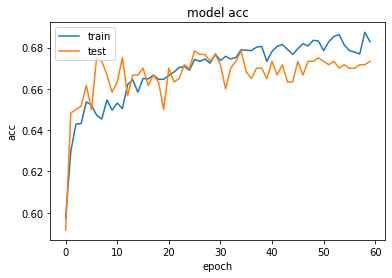

AUC score is:  0.4948419841801346
ACC score is:  0.5395


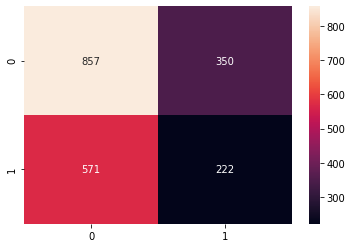

In [34]:
# General training controllers
epoch_number = 60    # learning seems to stabilize at this point
#-------------------------------------------------------------------

multi_model =  get_multimodel(
                        
                        text_inp_len, num_pred_len, num_of_treatments, cat_features_shape, diag_code_dim, 
                        
                        # MODELS to process textual data. 
                        # NOTE: If changin the model, need to change the input in the previous cell accordingly
                        #text_nn_model = get_model_lstm_own_embedding,
                        #text_nn_model = get_model_lstm_embedding_ready, # get_model_lstm_own_embedding, # 'get_model_lstm_embedding_ready'
                        text_nn_model = get_model_average_w2v,
    
                        # Hyper parameters of individual models
                        general_args = {"vocab_size": vocab_size, "learning_rate_adam": 0.01 },
                        
                        model_numeric_args = {"hidden_unit": 3, "activation": 'tanh'},
                        
                        medical_args = {"hidden_unit":2, "activation": 'tanh'},
                        
                        categ_args = {"hidden_unit":3, "activation": 'tanh'},
                        
                        model_text_args = {"embedding_size": 10, 
                                           "lstm_units": 16, 
                                           "w2v_embedding_size": W2V_EMBED_SIZE,    
                                           "dense_units": 16, "activation":'tanh',
                                           "activation_2" : "relu" },
                        
                        model_out_args = {"dense_out_1": 16, "dense_out_2": 16}
    
                       )

#print(multi_model.summary())


history = multi_model.fit(all_inputs, Y_train,
                          epochs=epoch_number,
                          batch_size=128,
                          verbose=0,
                          callbacks=callbacks_list,
                          validation_split=0.1)



#--------------- Training Histroy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#--------------- MODEL EVALUATION ON THE VALIDATION SET
y_pred_val = multi_model.predict(all_inputs_val)

print("AUC score is: ", metrics.roc_auc_score(Y_val, y_pred_val))
y_pred_val = (y_pred_val > 0.5).astype(np.int8)
print("ACC score is: ", metrics.accuracy_score(Y_val, y_pred_val))

#--------------- CONFUSION MATRIX (important since imbalanced)
cf_matrix = confusion_matrix(Y_val, y_pred_val)
sns.heatmap(cf_matrix, annot=True, fmt='g')
plt.show()

**Experiments**

The number of hyper parameters for our model is quite big, so a grid search would have taken too much time. We have decided insted, to concentrate on the few parameters and look at their impact on the prediction results. The parameters in question are: *type of the textual preprocessing model*, *w2v embedding size* and *number of the dense units* in the get_multimod() function

**Observations**

1. get_model_lstm_own_embedding seems to perform slightly worse than models with the **word2vec** embeddings. 
2. increasing embedding size for **word2vec** seems to slightly improve the predictions
3. increasing the number of lstm units from 16 to 32 does not seem to help a lot
4. decreasing the number of dense units decreases performance a bit.

**Miscellaneous**
1. models using `age category` slightly outperform the models with `age`
2. not balancing the dataset produces better results in terms of Accuracy score, since the distribution of positive and negative examples is the same accross *training*, *test* and *validation* datasets
3. due to the fact that our dataset is small, need to try to decrease the number of weights

# **Final model**

We retrain one of the promising models discovered during the hyperparameter tuning on *training* and *val* dataset and evaluate its performance on *test* dataset.

6 drugs left (out of 23) after filtering with threshold 0.95: 

Model: "model_16"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 30)           0                                            
__________________________________________________________________________________________________
input_9 (InputLayer)            (None, 30)           0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           (None, 30)           0                                            
__________________________________________________________________________________________________
dense_16 (Dense)                (None, 10)           310         input_8[0][0]                    
___________________________

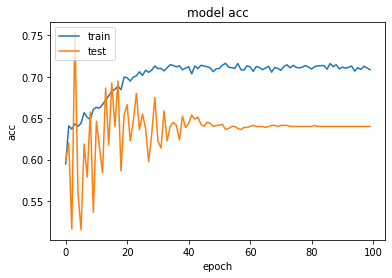

AUC score is:  0.6120011367067474
ACC score is:  0.6515


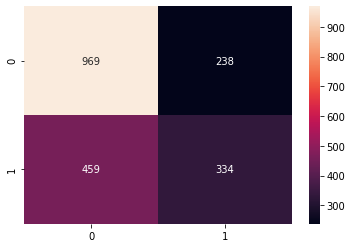

In [35]:
file_path_multi = "multi_input_mlp_final.h5"

checkpoint = ModelCheckpoint(file_path_multi, monitor='val_acc', verbose=0, save_best_only=True, mode='max')
early = EarlyStopping(monitor="val_acc", mode="max", patience=1000, verbose=0)
redonplat = ReduceLROnPlateau(monitor="val_acc", mode="max", patience=5, factor=0.5, verbose=0)
callbacks_list = [checkpoint, early, redonplat]

#-------------------------------------------------------------------

W2V_EMBED_SIZE = 30
epoch_number = 100  # learning seems to stabilize at this point

#-------------------------------------------------------------------

data_inp = data_loading_preprocessing(balance_data = True,
                               combine_train_and_val = True,
                               encode_as_missing = True,
                               missing_symbols = missing_symbols,
                               vars_to_delete = vars_to_delete,
                               vars_to_reencode = vars_to_reencode,
                               vars_to_impute = vars_to_impute )
    
X_train, Y_train, X_val, Y_val, X_test, Y_test = data_inp


inp_all_info = get_all_inputs(X_train, X_test, X_val,
                              
                              # Type of function to preprocess data
                              text_func=get_embedded_average,
                              
                              # Variables in different groups
                              numerical_features=numerical_features,
                              categorical_features=categorical_features,
                              medicine_all=medicine_all,
                              
                              # Arguments to different data preprocessing functions
                              args_numeric = {"sqrt_transform_features":['number_outpatient', 'number_emergency', 'number_inpatient']},
                              
                              args_med = {"is_binary_output": True, "perc_no_values_thresold": 0.95},
                              
                              args_text = {"num_words_tockenize": 500,  
                                           "max_sentence_len": 20, 
                                           "w2v_embedding_size": W2V_EMBED_SIZE}
                              )

all_inputs, all_inputs_val, all_inputs_test, input_dimensions, vocab_size = inp_all_info
num_pred_len, cat_features_shape, num_of_treatments, diag_code_dim, text_inp_len = input_dimensions

#-------------------------------------------------------------------

multi_model =  get_multimodel(
                        
                        text_inp_len, num_pred_len, num_of_treatments, cat_features_shape, diag_code_dim, 
                        
                        # MODELS to process textual data. 
                        text_nn_model = get_model_average_w2v,
    
                        # Hyper parameters of individual models
                        general_args = {"vocab_size": vocab_size, "learning_rate_adam": 0.01 },
                        
                        model_numeric_args = {"hidden_unit": 2, "activation": 'tanh'},
                        
                        medical_args = {"hidden_unit": 2, "activation": 'tanh'},
                        
                        categ_args = {"hidden_unit": 2, "activation": 'tanh'},
                        
                        model_text_args = {"embedding_size": 10, 
                                           "lstm_units": 8, 
                                           "w2v_embedding_size": W2V_EMBED_SIZE,    
                                           "dense_units": 8, "activation":'tanh',
                                           "activation_2" : "relu" },
                        
                        model_out_args = {"dense_out_1": 16, "dense_out_2": 16}
    
                       )

print(multi_model.summary())


history = multi_model.fit(all_inputs, Y_train,
                          epochs=epoch_number,
                          batch_size=128,
                          verbose=0,
                          callbacks=callbacks_list,
                          validation_split=0.1)



#--------------- Training Histroy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#--------------- MODEL EVALUATION ON THE TEST SET
y_pred_test = multi_model.predict(all_inputs_test)
y_pred_test = (y_pred_val > 0.5).astype(np.int8)

print("AUC score is: ", metrics.roc_auc_score(Y_test, y_pred_test))
y_pred_test = (y_pred_test > 0.5).astype(np.int8)
print("ACC score is: ", metrics.accuracy_score(Y_test, y_pred_test))

#--------------- CONFUSION MATRIX (important since imbalanced)
cf_matrix = confusion_matrix(Y_test, y_pred_test)
sns.heatmap(cf_matrix, annot=True, fmt='g')
plt.show()

## Final Remarks

In this notebook we have experimented with different architectures and different text representation methods. These experiments did not result in a better model than the model developed in `models.ipynb` however maybe this architecture could have certain potential for making the prediction on a full dataset